In [1]:
import os
import requests
import pandas as pd
import time 
import numpy as np
import pytz
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import descartes
import geopandas as gpd

from datetime import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, learning_curve, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_validate
from scipy.stats import randint
from sklearn import svm
from sklearn.feature_selection import r_regression
from sklearn.neighbors import KNeighborsClassifier
from shapely.geometry import Point, Polygon

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
def get_data(path, file_names):
    tables=[]
    for file_name in file_names:
        table = pd.read_csv(f'../{path}/{file_name}.csv')
        table['type']=f'{file_name}'
        tables.append(table)
    return pd.concat(tables)

path='data/raw_data'
file_names = ['128_fishing_trajs2', '128_fishing_trajs2']

df = get_data(path, file_names)

df.head()

,id,t,longitude,latitude,x,y,signed_turn,bearing,time_gap,distance_gap,euc_speed,distanceToShore,label,type
0,211477000-2,2021-11-14 15:00:10,12.310170,56.127777,705723.070725,6.225237e+06,-1.234666,309.501333,4.0,2.979797,1.448065,6.726540,01-sailing,128_fishing_trajs2
1,211477000-2,2021-11-14 15:00:13,12.310137,56.127788,705720.961925,6.225238e+06,-8.618680,300.882654,3.0,2.390153,1.548695,7.100549,01-sailing,128_fishing_trajs2
2,211477000-2,2021-11-14 15:00:16,12.310103,56.127800,705718.785662,6.225240e+06,1.461697,302.344350,3.0,2.501440,1.620804,8.239544,01-sailing,128_fishing_trajs2
3,211477000-2,2021-11-14 15:00:18,12.310067,56.127815,705716.469132,6.225241e+06,4.437298,306.781649,2.0,2.793416,2.714983,10.248085,01-sailing,128_fishing_trajs2
4,211477000-2,2021-11-14 15:00:22,12.310025,56.127830,705713.779868,6.225243e+06,-4.130020,302.651628,4.0,3.100555,1.506749,12.710248,01-sailing,128_fishing_trajs2


In [26]:
df['id'].nunique()

123

In [24]:
df['label'].unique()

array(['01-sailing', '02-fishing', '03-sailing', '04-fishing',
       '05-sailing'], dtype=object)

In [31]:
filtered_df = df.loc[df['label'].isin(['02-fishing', '04-fishing'])]

In [32]:
filtered_df.head()

,id,t,longitude,latitude,x,y,signed_turn,bearing,time_gap,distance_gap,euc_speed,distanceToShore,label,type
390,211477000-2,2021-11-14 16:11:19,12.330402,56.224358,706460.597481,6.236040e+06,-0.069903,1.571579,11.0,42.889636,7.579162,10686.228837,02-fishing,128_fishing_trajs2
391,211477000-2,2021-11-14 16:11:22,12.330407,56.224502,706460.132556,6.236056e+06,-0.465709,1.105871,3.0,16.038779,10.392297,10702.180264,02-fishing,128_fishing_trajs2
392,211477000-2,2021-11-14 16:11:25,12.330387,56.224608,706458.322937,6.236068e+06,-7.093961,354.011909,3.0,11.869146,7.690591,10713.741486,02-fishing,128_fishing_trajs2
393,211477000-2,2021-11-14 16:11:29,12.330335,56.224748,706454.347505,6.236084e+06,-5.678980,348.332930,4.0,15.920604,7.736795,10728.817284,02-fishing,128_fishing_trajs2
394,211477000-2,2021-11-14 16:11:33,12.330262,56.224882,706449.103108,6.236098e+06,-5.182386,343.150544,4.0,15.594267,7.578208,10743.073282,02-fishing,128_fishing_trajs2


In [33]:
geometry = [Point(xy) for xy in zip(filtered_df['longitude'], filtered_df['latitude'])]
crs = {'init':'epsg:4326'}
fishing_gps = gpd.GeoDataFrame(filtered_df, #specify our data
                          crs=crs, #specify our coordinate reference system
                          geometry=geometry) #specify the geometry list we created
fishing_gps.head()

,id,t,longitude,latitude,x,y,signed_turn,bearing,time_gap,distance_gap,euc_speed,distanceToShore,label,type,geometry
390,211477000-2,2021-11-14 16:11:19,12.330402,56.224358,706460.597481,6.236040e+06,-0.069903,1.571579,11.0,42.889636,7.579162,10686.228837,02-fishing,128_fishing_trajs2,POINT (12.33040 56.22436)
391,211477000-2,2021-11-14 16:11:22,12.330407,56.224502,706460.132556,6.236056e+06,-0.465709,1.105871,3.0,16.038779,10.392297,10702.180264,02-fishing,128_fishing_trajs2,POINT (12.33041 56.22450)
392,211477000-2,2021-11-14 16:11:25,12.330387,56.224608,706458.322937,6.236068e+06,-7.093961,354.011909,3.0,11.869146,7.690591,10713.741486,02-fishing,128_fishing_trajs2,POINT (12.33039 56.22461)
393,211477000-2,2021-11-14 16:11:29,12.330335,56.224748,706454.347505,6.236084e+06,-5.678980,348.332930,4.0,15.920604,7.736795,10728.817284,02-fishing,128_fishing_trajs2,POINT (12.33033 56.22475)
394,211477000-2,2021-11-14 16:11:33,12.330262,56.224882,706449.103108,6.236098e+06,-5.182386,343.150544,4.0,15.594267,7.578208,10743.073282,02-fishing,128_fishing_trajs2,POINT (12.33026 56.22488)


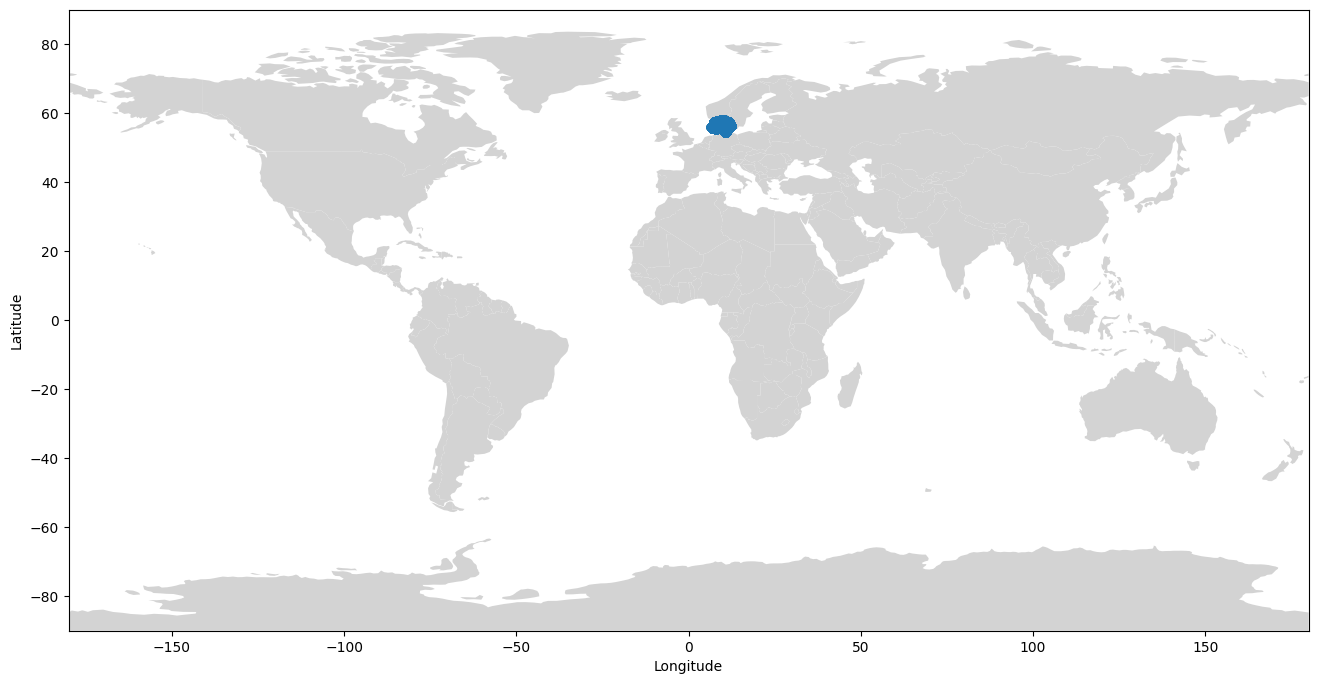

In [35]:
# Getting world map data from geo pandas
worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# Creating axes and plotting world map
fig, ax = plt.subplots(figsize=(16, 10))
worldmap.plot(color="lightgrey", ax=ax)

# Plotting Longitudes and Latitudes of one boat
x = fishing_gps['longitude']
y = fishing_gps['latitude']
plt.scatter(x, y, cmap='autumn')

# Creating axis limits and title
plt.xlim([-180, 180])
plt.ylim([-90, 90])

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()